In [16]:
import networkx as nx
import numpy as np
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [17]:
#### Generate a grid graph
from networkx import grid_graph
import scipy as sc
from scipy.sparse.linalg import eigsh

dim_grid = 2
k = 10
G = grid_graph(dim=[k] * dim_grid)

#### Create a bunch of features for my graph
L = nx.laplacian_matrix(G)
from scipy.sparse.linalg import eigs
n  = nx.number_of_nodes(G)
p = 20
X = np.zeros((n, p))

eigenvalues, eigenvectors = eigs(L.astype(float), k=p)
# Print the eigenvectors
print(eigenvectors)
#### Use the eigenvectors to define features
for i in np.arange(n):
    X[i,:] = np.random.multivariate_normal(mean=eigenvectors[i,:].real, cov=np.eye(p))

### Now, I need to define a function on the graph that should be reasonably smooth
beta_1 = np.array(np.random.uniform(size=p))
beta_2 = np.array(np.random.uniform(size=p))
A = nx.adjacency_matrix(G)
Dinv = np.diag(1 / A.sum(1))
S = Dinv @ A
Y = X @ beta_1 + S @ X @ beta_2


[[-0.00489435+0.j  0.0190983 +0.j  0.01347877+0.j ... -0.05316788+0.j
   0.03427731+0.j -0.01158853+0.j]
 [ 0.01420395+0.j -0.05      +0.j -0.03752847+0.j ...  0.12167317+0.j
  -0.020403  +0.j  0.0617054 +0.j]
 [-0.02212317+0.j  0.0618034 +0.j  0.05374605+0.j ... -0.12618128+0.j
  -0.07060073+0.j -0.11650549+0.j]
 ...
 [-0.02212317+0.j  0.0618034 +0.j -0.05374605+0.j ...  0.12618128+0.j
   0.07060073+0.j  0.11650549+0.j]
 [ 0.01420395+0.j -0.05      +0.j  0.03752847+0.j ... -0.12167317+0.j
   0.020403  +0.j -0.0617054 +0.j]
 [-0.00489435+0.j  0.0190983 +0.j -0.01347877+0.j ...  0.05316788+0.j
  -0.03427731+0.j  0.01158853+0.j]]


In [27]:
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected
edge_index, edge_weights = from_scipy_sparse_matrix(A)
edge_index, edge_weights = to_undirected(edge_index, edge_weights)
M = torch.max(edge_weights)
data = Data(x=torch.from_numpy(X).float(),
                y = torch.from_numpy(Y).float(),
                    edge_index=edge_index,
                    edge_weight=edge_weights)

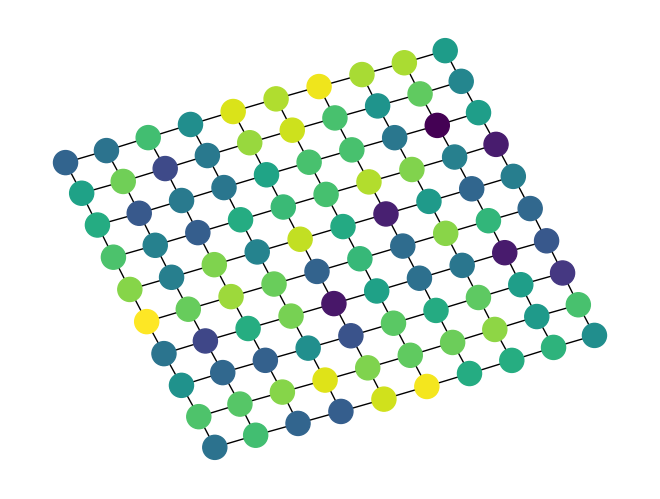

In [19]:
import matplotlib.pyplot as plt

values = Y # Extract values based on node order
# Plot the function
plt.figure(figsize=(8, 6))
plt.contourf(x, y, test[:,2].reshape(x.shape), cmap='viridis')
plt.colorbar(label='Function Value')
plt.title('2D Gaussian Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show())


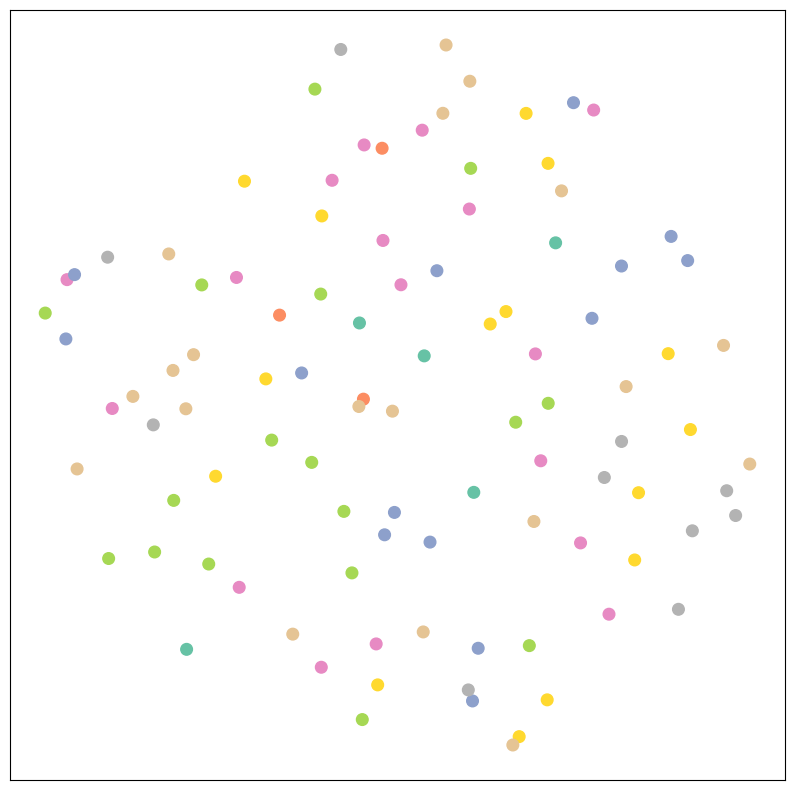

In [20]:
import matplotlib.pyplot as plt
import umap

reducer = umap.UMAP()
z= reducer.fit_transform(X)

plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])

plt.scatter(z[:, 0], z[:, 1], s=70, c=Y, cmap="Set2")
plt.show()

In [21]:
### Fit a GNN to predict what Y is:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels=1):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv2(x, edge_index)
        return x

model = GCN(input_dim=p, hidden_channels=1)

In [22]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    reducer = umap.UMAP()
    z= reducer.fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [23]:
z.shape

(100, 2)

In [24]:
model = GCN(input_dim=p, hidden_channels=1)
model.eval()

out = model(data.x, data.edge_index)
#visualize(out, color=Y)

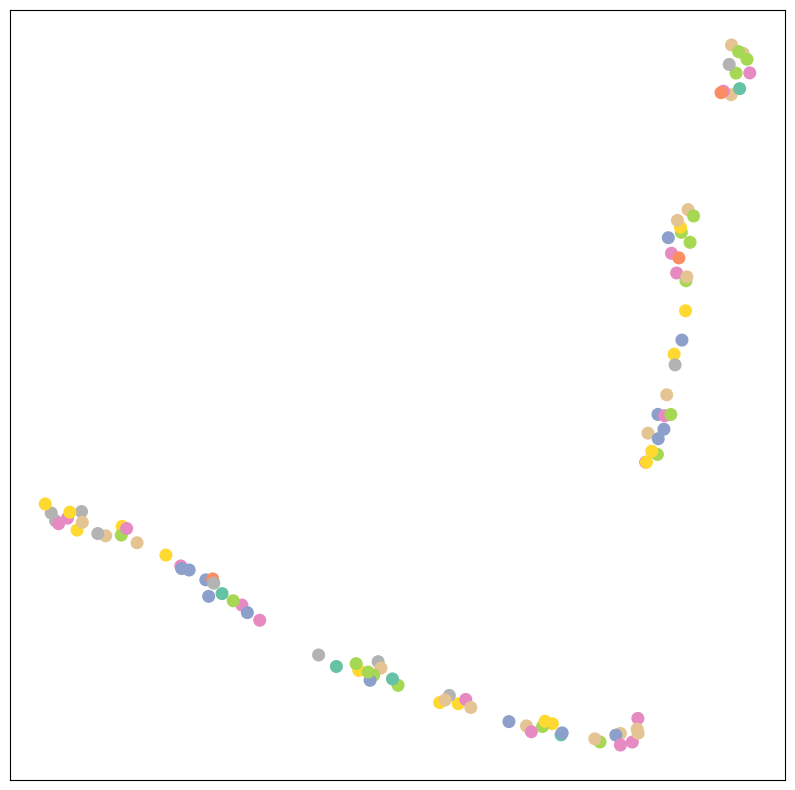

In [25]:
visualize(out, color=Y)

In [39]:
model = GCN(input_dim=p, hidden_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()


data.train_mask = np.random.binomial(n=1, p=0.75, size=n)
data.test_mask = 1-data.train_mask
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      pred = model(data.x, data.edge_index)
      test_acc = criterion(pred[data.test_mask], data.y[data.test_mask])  # Check against ground-truth labels.
      #test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 2.1755
Epoch: 002, Loss: 1.9206
Epoch: 003, Loss: 1.6828
Epoch: 004, Loss: 1.4625
Epoch: 005, Loss: 1.2598
Epoch: 006, Loss: 1.0749
Epoch: 007, Loss: 0.9077
Epoch: 008, Loss: 0.7580
Epoch: 009, Loss: 0.6257
Epoch: 010, Loss: 0.5104
Epoch: 011, Loss: 0.4115
Epoch: 012, Loss: 0.3282
Epoch: 013, Loss: 0.2599
Epoch: 014, Loss: 0.2054
Epoch: 015, Loss: 0.1636
Epoch: 016, Loss: 0.1333
Epoch: 017, Loss: 0.1129
Epoch: 018, Loss: 0.1011
Epoch: 019, Loss: 0.0964
Epoch: 020, Loss: 0.0971
Epoch: 021, Loss: 0.1019
Epoch: 022, Loss: 0.1094
Epoch: 023, Loss: 0.1183
Epoch: 024, Loss: 0.1276
Epoch: 025, Loss: 0.1363
Epoch: 026, Loss: 0.1439
Epoch: 027, Loss: 0.1498
Epoch: 028, Loss: 0.1538
Epoch: 029, Loss: 0.1556
Epoch: 030, Loss: 0.1554
Epoch: 031, Loss: 0.1534
Epoch: 032, Loss: 0.1496
Epoch: 033, Loss: 0.1446
Epoch: 034, Loss: 0.1386
Epoch: 035, Loss: 0.1321
Epoch: 036, Loss: 0.1252
Epoch: 037, Loss: 0.1185
Epoch: 038, Loss: 0.1121
Epoch: 039, Loss: 0.1063
Epoch: 040, Loss: 0.1012


In [40]:
test_acc = test()
print(f'Test MSE: {test_acc:.4f}')

Test Accuracy: 0.2396


In [41]:
pred = model(data.x, data.edge_index)
train_acc = criterion(pred[data.train_mask], data.y[data.train_mask]) 
print(f'Train MSE: {train_acc:.4f}')

Train MSE: 0.0882
